## Parsing Objects and Walls Data

In [926]:
import json
import os
import pandas as pd
import numpy as np

In [927]:
data_path = r"C:\Users\ethan_haque\Desktop\tmp\objects_wall_hanging"

In [928]:
def get_json_files(path):
    json_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".json"):
                json_files.append(os.path.join(root, file))
    return json_files

In [929]:
objects_and_walls_via_json_file_paths = get_json_files(data_path)

In [930]:
def parse_via_json_file(via_json_file_path):
    with open(via_json_file_path, encoding="utf8") as f:
        data = json.load(f)

    return data["_via_img_metadata"]


In [931]:
def validate_dei_selections(image_id, image_info):
    dei_errors = []
    if "file_attributes" not in image_info:
        dei_errors.append({"image_id": image_id, "error": "No file attributes"})
        return dei_errors

    selections = image_info["file_attributes"]

    categories = set(selections["category"].keys())
    diversity_categories = set(selections["diversity category"].keys())
    identity_categories = set(selections["identity category"].keys())

    if (not categories) and (not diversity_categories) and (not identity_categories):
        dei_errors.append({"image_id": image_id, "error": "No categories, diversity categories, or identity categories"})
        return dei_errors
    if not categories:
        dei_errors.append({"image_id": image_id, "error": "No categories"})
    if not diversity_categories:
        dei_errors.append({"image_id": image_id, "error": "No diversity categories"})
    if not identity_categories:
        dei_errors.append({"image_id": image_id, "error": "No identity categories"})

    validate_none_category(image_id, categories, diversity_categories, identity_categories, dei_errors)
    validate_diversity_inclusion_category(image_id, categories, diversity_categories, dei_errors)
    validate_diversity_category(image_id, diversity_categories, identity_categories, dei_errors)

    return dei_errors


def validate_none_category(image_id, categories, diversity_categories, identity_categories, errors):
    if "none" in categories:
        if len(categories) > 1:
            errors.append({"image_id": image_id, "error": "Category 'none' and other categories"})
        if diversity_categories != {"NA"}:
            errors.append({"image_id": image_id, "error": "Category 'none' and diversity category not 'NA'"})
        if identity_categories != {"NA"}:
            errors.append({"image_id": image_id, "error": "Category 'none' and identity category not 'NA'"})


def validate_diversity_inclusion_category(image_id, categories, diversity_categories, errors):
    if "diversity and inclusion" in categories and diversity_categories == {"NA"}:
        errors.append({"image_id": image_id, "error": "Category 'diversity and inclusion' and diversity category 'NA'"})
    elif "diversity and inclusion" not in categories and diversity_categories != {"NA"}:
        errors.append(
            {"image_id": image_id, "error": "Category not 'diversity and inclusion' and diversity category not 'NA'"})


def validate_diversity_category(image_id, diversity_categories, identity_categories, errors):
    if "explicitly identity-affirming" in diversity_categories or "minority/marginalized representation" in diversity_categories:
        if identity_categories == {"NA"}:
            errors.append({"image_id": image_id, "error": "Diversity category not 'NA' and identity category 'NA'"})
    elif identity_categories != {"NA"}:
        errors.append({"image_id": image_id, "error": "Diversity category 'NA' and identity category not 'NA'"})


def create_one_hot_coding_labels(possible_categories, selected_categories):
    return [True if category in selected_categories else False for category in possible_categories]

def get_file_information(file_path):
    parent_dir = os.path.dirname(file_path)
    batch_name = "_".join(parent_dir.split(" ")[:-1]).split("\\")[-1].lower()
    batch_type = parent_dir.split(" ")[-1].lower()
    file_name = os.path.basename(file_path)
    ra_coder = os.path.dirname(parent_dir).split("\\")[-1].lower()

    return {"ra_coder": ra_coder, "batch_name": batch_name, "batch_type": batch_type, "json_file_path": file_path,
            "json_file_name": file_name}

In [932]:
# file_information = ["ra_coder", "batch_name", "batch_type", "json_file_path", "json_file_name"]
image_information = ["image_id", "error"]
category_information = ["indiscernible", "none", "diversity and inclusion", "majority/dominant representation",
                        "hate symbols", "sports", "sci fi", "other", "ambiguous"]
diversity_information = ["NA", "explicitly identity-affirming", "minority/marginalized representation",
                         "diversity/multiculturalism general", "belonging general", "other", "ambiguous"]
identity_information = ["NA", "bipoc", "non-cis man", "lgbq", "non-christian", "disability", "other", "ambiguous"]

category_information_with_prefix = ["category " + category for category in category_information]
diversity_information_with_prefix = ["diversity category " + diversity for diversity in diversity_information]
identity_information_with_prefix = ["identity category " + identity for identity in identity_information]

rows = []
for file_path in objects_and_walls_via_json_file_paths:
    via_image_data = parse_via_json_file(file_path)
    file_information = get_file_information(file_path)
    for img_id, img_info in via_image_data.items():
        dei_errors = validate_dei_selections(img_id, img_info)
        error_str = ""
        if dei_errors:
            error_str = "\n".join([error["error"] for error in dei_errors])

        selected_categories = list(img_info["file_attributes"]["category"].keys())
        selected_diversity_categories = list(img_info["file_attributes"]["diversity category"].keys())
        selected_identity_categories = list(img_info["file_attributes"]["identity category"].keys())

        one_hot_coding_categories = create_one_hot_coding_labels(category_information, selected_categories)
        one_hot_coding_diversity = create_one_hot_coding_labels(diversity_information, selected_diversity_categories)
        one_hot_coding_identity = create_one_hot_coding_labels(identity_information, selected_identity_categories)



        row = {"image_id": img_id, "error": error_str, **file_information,
               **dict(zip(category_information_with_prefix, one_hot_coding_categories)),
               **dict(zip(diversity_information_with_prefix, one_hot_coding_diversity)),
               **dict(zip(identity_information_with_prefix, one_hot_coding_identity))}

        rows.append(row)


In [933]:
object_wall_hanging_df = pd.DataFrame(rows)

In [934]:
rebatched_data_path = r"C:\Users\ethan_haque\Desktop\tmp\Emily"

In [935]:
rebatched_json_file_paths = get_json_files(rebatched_data_path)
via_image_data = parse_via_json_file(rebatched_json_file_paths[0])
file_information = get_file_information(rebatched_json_file_paths[0])

rows = []
for img_id, img_info in via_image_data.items():
    dei_errors = validate_dei_selections(img_id, img_info)
    error_str = ""
    if dei_errors:
        error_str = "\n".join([error["error"] for error in dei_errors])

    selected_categories = list(img_info["file_attributes"]["category"].keys())
    selected_diversity_categories = list(img_info["file_attributes"]["diversity category"].keys())
    selected_identity_categories = list(img_info["file_attributes"]["identity category"].keys())

    one_hot_coding_categories = create_one_hot_coding_labels(category_information, selected_categories)
    one_hot_coding_diversity = create_one_hot_coding_labels(diversity_information, selected_diversity_categories)
    one_hot_coding_identity = create_one_hot_coding_labels(identity_information, selected_identity_categories)
    
    row = {"image_id": img_id, "error": error_str, **file_information,
           **dict(zip(category_information_with_prefix, one_hot_coding_categories)),
           **dict(zip(diversity_information_with_prefix, one_hot_coding_diversity)),
           **dict(zip(identity_information_with_prefix, one_hot_coding_identity))}
    
    
    rows.append(row) 
    
rebatched_df = pd.DataFrame(rows)

In [936]:
# need to reset batch_type based on image_id. Split image_id on "_" and take the 3rd element (index 2).
rebatched_df["batch_type"] = rebatched_df["image_id"].str.split("_").str[2]
rebatched_df["batch_type"] = rebatched_df["batch_type"].str.replace("poster-wall-hanging", "walls")
rebatched_df["batch_type"] = rebatched_df["batch_type"].str.replace("object", "objects")
rebatched_df

,image_id,error,ra_coder,batch_name,batch_type,json_file_path,json_file_name,category indiscernible,category none,category diversity and inclusion,...,diversity category other,diversity category ambiguous,identity category NA,identity category bipoc,identity category non-cis man,identity category lgbq,identity category non-christian,identity category disability,identity category other,identity category ambiguous
0,user16_2800_object_4_4.jpg4990,,emily,rebatch_1,objects,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,user16_2800_object_10_19.jpg4623,,emily,rebatch_1,objects,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,user37_235_poster-wall-hanging_1_0.jpg9469,,emily,rebatch_1,walls,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
3,user81_4081_poster-wall-hanging_7_12.jpg8930,,emily,rebatch_1,walls,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,user106_344_object_2_19.jpg1954,,emily,rebatch_1,objects,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,user2944_935_object_2_4.jpg4329,,emily,rebatch_1,objects,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,True,False,...,False,False,True,False,False,False,False,False,False,False
124,user2955_945_poster-wall-hanging_2_1.jpg15884,,emily,rebatch_1,walls,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,False,True,...,False,False,False,True,True,True,False,False,True,False
125,user2959_948_poster-wall-hanging_4_12.jpg11639,,emily,rebatch_1,walls,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,False,True,...,False,False,False,True,True,False,False,False,False,False
126,user2962_953_poster-wall-hanging_1_0.jpg5758,,emily,rebatch_1,walls,C:\Users\ethan_haque\Desktop\tmp\Emily\rebatch...,Emily rebatched 9_21 (1).json,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [937]:
# concat the two dataframes
object_wall_hanging_df = pd.concat([object_wall_hanging_df, rebatched_df], ignore_index=True)

In [938]:
object_wall_hanging_df["filename"] = object_wall_hanging_df["image_id"].str.replace(r"(?<=\.jpg)\d+$", "", regex=True)

# put the filename col at the front
cols = object_wall_hanging_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
object_wall_hanging_df = object_wall_hanging_df[cols]

In [939]:
print("Number of unique filenames: {}".format(len(object_wall_hanging_df["filename"].unique())))

Number of unique filenames: 21013


In [940]:
# get rid of duplicate rows that have been rebatched and keep the rebatched rows

# Identify filenames that are duplicated and at least one "rebatch" exists for those
filenames_to_filter = object_wall_hanging_df[object_wall_hanging_df["batch_name"].str.contains("rebatch")]["filename"].unique()

# Filter the DataFrame to keep rows with those filenames but only if they contain "rebatch"
rebatch_rows = object_wall_hanging_df[(object_wall_hanging_df["filename"].isin(filenames_to_filter)) & (object_wall_hanging_df["batch_name"].str.contains("rebatch"))]

# Filter the DataFrame to get rows that either aren't in the filenames_to_filter list or have "rebatch"
object_wall_hanging_df = pd.concat([object_wall_hanging_df[~object_wall_hanging_df["filename"].isin(filenames_to_filter)], rebatch_rows])


In [941]:
non_keys = ["image_id", "error", "ra_coder", "batch_name", "batch_type", "json_file_path", "json_file_name", "category none", "category indiscernible"]
object_wall_hanging_df = object_wall_hanging_df.drop_duplicates(subset=[col for col in object_wall_hanging_df.columns if col not in non_keys], keep="last")

In [942]:
object_wall_hanging_df = object_wall_hanging_df.sort_values(by=["filename", "ra_coder"])
print("Number of unique filenames: {}".format(len(object_wall_hanging_df["filename"].unique())))

Number of unique filenames: 21013


In [943]:
images_to_remove = ['User81_4081_poster-wall-hanging_7_12.jpg', 'User300_4685_poster-wall-hanging_3_2.jpg', 'User350_1057_poster-wall-hanging_5_4.jpg', 'User354_300_poster-wall-hanging_7_6.jpg', 'User460_1752_poster-wall-hanging_1_0.jpg', 'User599_4836_poster-wall-hanging_3_2.jpg', 'User789_3479_poster-wall-hanging_3_2.jpg', 'User1181_2936_object_6_9.jpg', 'user2192_3880_poster-wall-hanging_4_3.jpg', 'user2357_3924_poster-wall-hanging_2_1.jpg', 'user2422_1442_poster-wall-hanging_3_2.jpg', 'user2491_1463_poster-wall-hanging_2_2.jpg', 'user2959_948_poster-wall-hanging_4_12.jpg']

images_to_remove = [image.lower() for image in images_to_remove]

object_wall_hanging_df = object_wall_hanging_df[~object_wall_hanging_df["filename"].isin(images_to_remove)]
print("Number of unique filenames: {}".format(len(object_wall_hanging_df["filename"].unique())))


Number of unique filenames: 21000


In [944]:
# convert all bool columns to int
bool_cols = [col for col in object_wall_hanging_df if object_wall_hanging_df[col].dtype == "bool"]
object_wall_hanging_df[bool_cols] = object_wall_hanging_df[bool_cols].astype(int)

In [945]:
# show duplicates by filename
object_wall_hanging_df.groupby("filename").filter(lambda x: len(x) > 1).sort_values(by=["filename", "ra_coder"])

,filename,image_id,error,ra_coder,batch_name,batch_type,json_file_path,json_file_name,category indiscernible,category none,...,diversity category other,diversity category ambiguous,identity category NA,identity category bipoc,identity category non-cis man,identity category lgbq,identity category non-christian,identity category disability,identity category other,identity category ambiguous
17945,user1047_2289_poster-wall-hanging_15_15.jpg,user1047_2289_poster-wall-hanging_15_15.jpg7631,,sabrina,training_batch_2,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,SalamSabrina2976_175.json,0,1,...,0,0,1,0,0,0,0,0,0,0
23545,user1047_2289_poster-wall-hanging_15_15.jpg,user1047_2289_poster-wall-hanging_15_15.jpg7631,,stephanie,training_batch_2,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,Stephanie User73 - User2976.json,0,0,...,0,0,1,0,0,0,0,0,0,0
17820,user106_358_object_3_14.jpg,user106_358_object_3_14.jpg2488,,sabrina,training_batch_2,objects,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,SalamSabrina2937_925.json,0,1,...,0,0,1,0,0,0,0,0,0,0
23420,user106_358_object_3_14.jpg,user106_358_object_3_14.jpg2488,,stephanie,training_batch_2,objects,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,Stephanie User32 - User29377.json,0,0,...,0,0,1,0,0,0,0,0,0,0
17821,user106_361_object_10_27.jpg,user106_361_object_10_27.jpg1664,,sabrina,training_batch_2,objects,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,SalamSabrina2937_925.json,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18346,user789_4056_poster-wall-hanging_1_0.jpg,user789_4056_poster-wall-hanging_1_0.jpg7015,,sabrina,training_batch_4a,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,3_27SalamSabrina2987_189.json,0,1,...,0,0,1,0,0,0,0,0,0,0
17742,user835_4073_poster-wall-hanging_6_5.jpg,user835_4073_poster-wall-hanging_6_5.jpg21735,,sabrina,training_batch_1,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,SalamSabrina2855complete1 (1).json,0,0,...,0,0,0,0,1,0,0,0,0,0
23342,user835_4073_poster-wall-hanging_6_5.jpg,user835_4073_poster-wall-hanging_6_5.jpg21735,,stephanie,training_batch_1,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,Stephanie User 2855.json,0,1,...,0,0,1,0,0,0,0,0,0,0
17942,user958_1070_poster-wall-hanging_6_7.jpg,user958_1070_poster-wall-hanging_6_7.jpg9695,,sabrina,training_batch_2,walls,C:\Users\ethan_haque\Desktop\tmp\objects_wall_...,SalamSabrina2976_175.json,1,0,...,0,0,1,0,0,0,0,0,0,0


In [946]:
object_wall_hanging_df.to_csv("../object_wall_hanging_report/object_wall_hanging_coding.csv", index=False)

## Visualizations

In [947]:
import seaborn as sns
sns.set_style("ticks")
sns.set(rc={"figure.figsize": (15, 7.5)})
sns.set(font_scale=1.25)

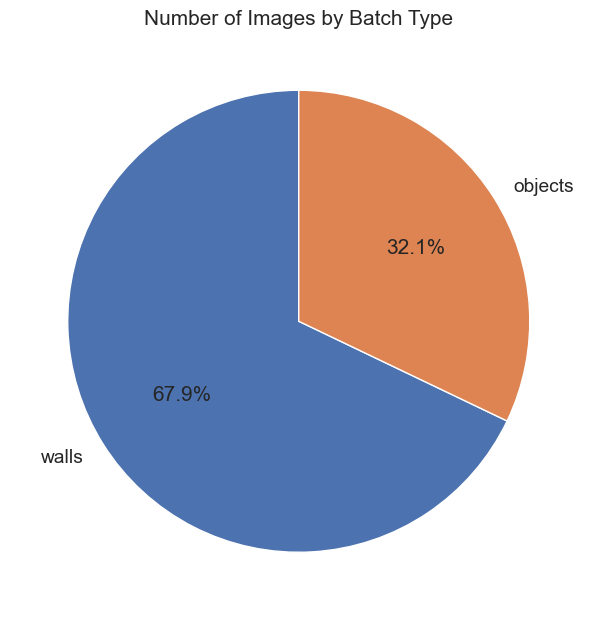

In [948]:
# plot and save image
images_by_batch_type = object_wall_hanging_df["batch_type"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90)
images_by_batch_type.set_title("Number of Images by Batch Type")
images_by_batch_type.set_ylabel("")
figure = images_by_batch_type.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type.png", bbox_inches="tight")

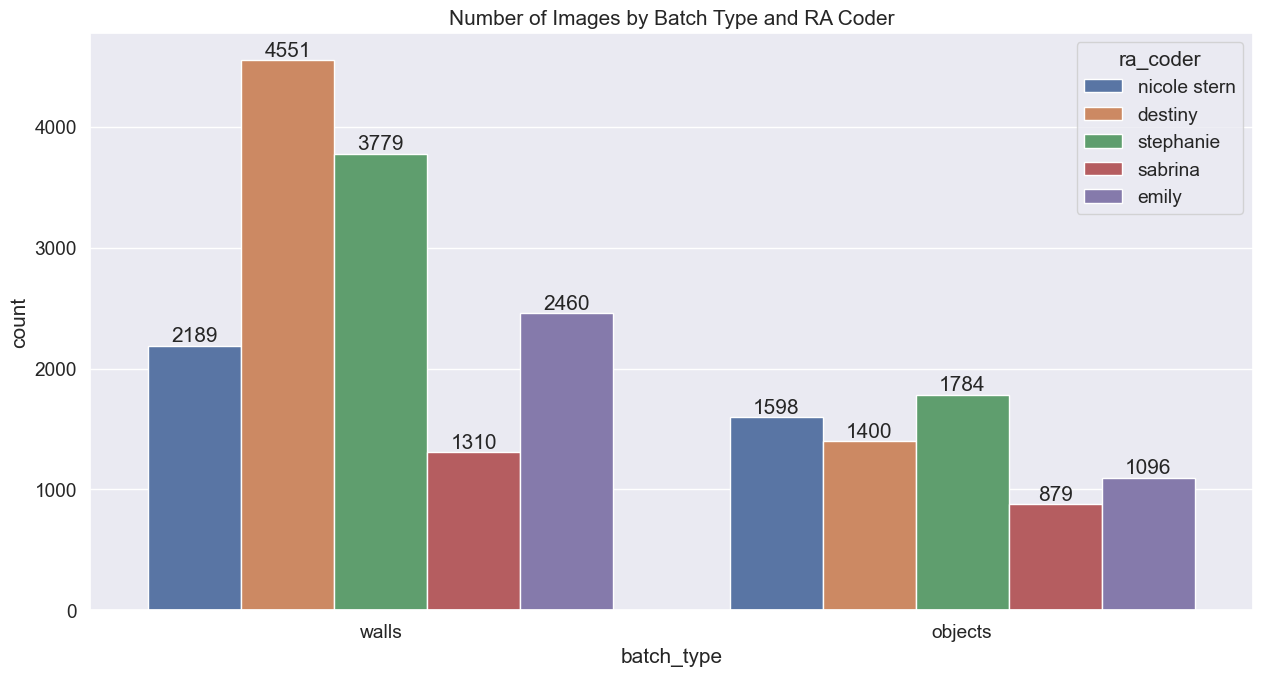

In [949]:
images_by_batch_type_and_ra_coder = sns.countplot(x="batch_type", hue="ra_coder", data=object_wall_hanging_df)
images_by_batch_type_and_ra_coder.set_title("Number of Images by Batch Type and RA Coder")

for p in images_by_batch_type_and_ra_coder.patches:
    height = p.get_height()
    images_by_batch_type_and_ra_coder.text(p.get_x() + p.get_width()/2., height,
            '{:d}'.format(int(height)), 
            ha="center", va="bottom")
    
figure = images_by_batch_type_and_ra_coder.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type_and_ra_coder.png", bbox_inches="tight")

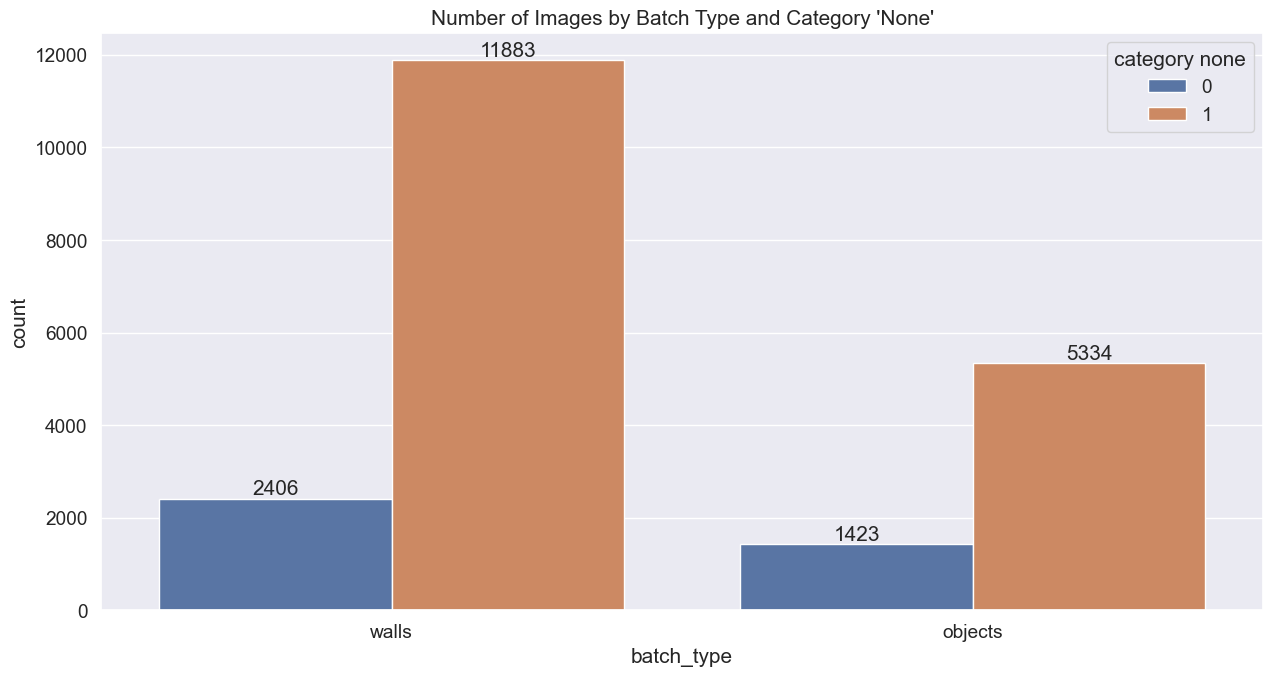

In [950]:
images_by_batch_type_and_category_none = sns.countplot(x="batch_type", hue="category none", data=object_wall_hanging_df)
images_by_batch_type_and_category_none.set_title("Number of Images by Batch Type and Category 'None'")

for p in images_by_batch_type_and_category_none.patches:
    height = p.get_height()
    images_by_batch_type_and_category_none.text(p.get_x() + p.get_width()/2., height,
            '{:d}'.format(int(height)), 
            ha="center", va="bottom")

figure = images_by_batch_type_and_category_none.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_batch_type_and_category_none.png", bbox_inches="tight")

In [951]:
# # display number of images with an error (i.e. error is not the empty string) by ra_coder
# errors = object_wall_hanging_df[object_wall_hanging_df["error"] != ""]
# num_errors = errors["ra_coder"].value_counts()
# images_with_errors_by_ra_coder = sns.barplot(x=num_errors.index, y=num_errors.values)
# images_with_errors_by_ra_coder.set_ylabel("Count")
# images_with_errors_by_ra_coder.set_title("Number of Images with Errors by RA Coder")
# 
# for p in images_with_errors_by_ra_coder.patches:
#     height = p.get_height()
#     images_with_errors_by_ra_coder.text(p.get_x() + p.get_width()/2., height,
#             '{:d}'.format(int(height)), 
#             ha="center", va="bottom")
# 
# figure = images_with_errors_by_ra_coder.get_figure()
# figure.savefig("../object_wall_hanging_report/images_with_errors_by_ra_coder.png", bbox_inches="tight")

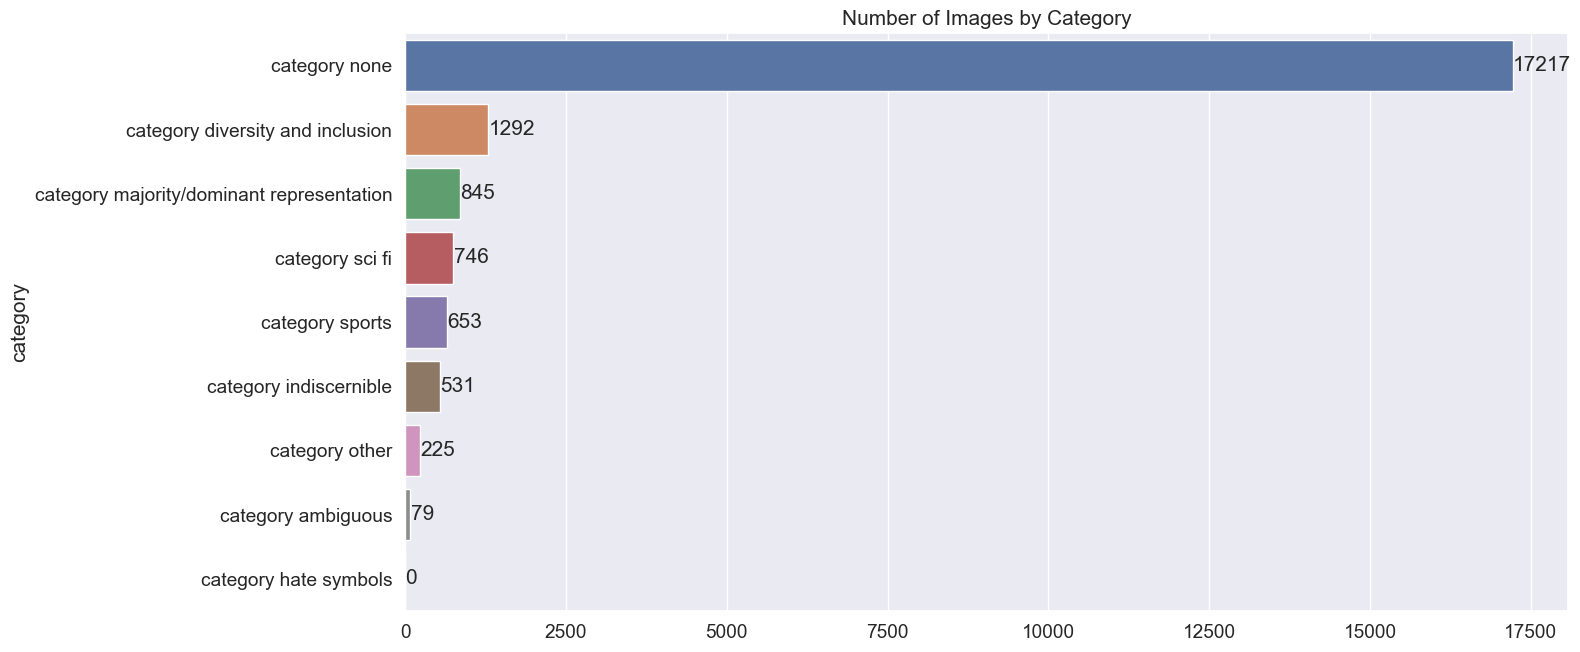

In [952]:
# show distribution among category
category_cols = [col for col in object_wall_hanging_df.columns if col.startswith("category")]
category_df = object_wall_hanging_df[category_cols]
category_df = category_df.melt(var_name="category", value_name="selected")
category_df = category_df[category_df["selected"] == True]
category_df_counts = category_df["category"].value_counts()

# add missing categories and set to 0
for category in category_information_with_prefix:
    if category not in category_df_counts.index:
        category_df_counts[category] = 0

images_by_category = sns.barplot(x=category_df_counts.values, y=category_df_counts.index)
images_by_category.set_title("Number of Images by Category")

for p in images_by_category.patches:
    width = p.get_width()
    images_by_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_category.png", bbox_inches="tight")

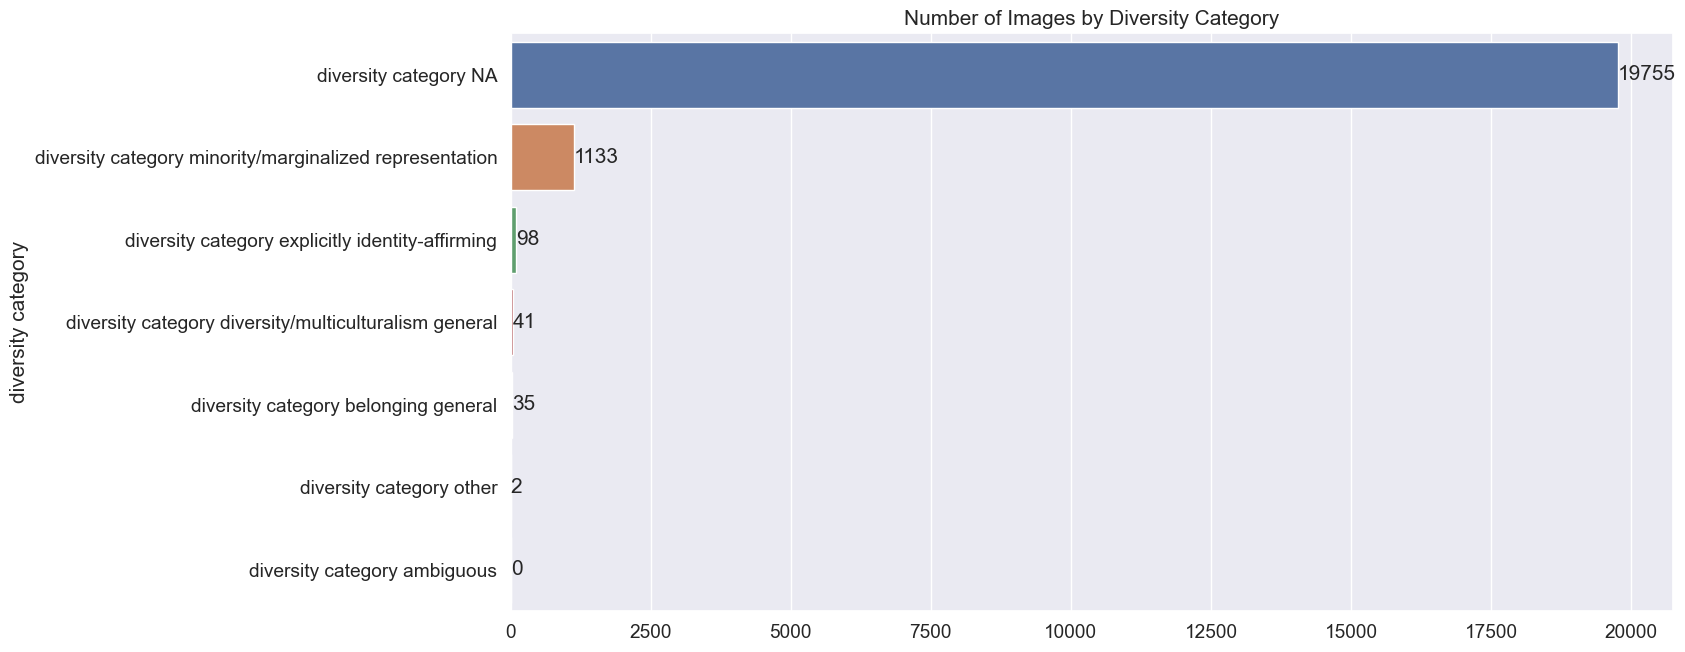

In [953]:
# show distribution among diversity_category
diversity_cols = [col for col in object_wall_hanging_df.columns if col.startswith("diversity category")]
diversity_df = object_wall_hanging_df[diversity_cols]
diversity_df = diversity_df.melt(var_name="diversity category", value_name="selected")
diversity_df = diversity_df[diversity_df["selected"] == True]
diversity_df_counts = diversity_df["diversity category"].value_counts()

# add missing categories and set to 0
for diversity_category in diversity_information_with_prefix:
    if diversity_category not in diversity_df_counts.index:
        diversity_df_counts[diversity_category] = 0

images_by_diversity_category = sns.barplot(x=diversity_df_counts.values, y=diversity_df_counts.index)
images_by_diversity_category.set_title("Number of Images by Diversity Category")

for p in images_by_diversity_category.patches:
    width = p.get_width()
    images_by_diversity_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_diversity_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_diversity_category.png", bbox_inches="tight")

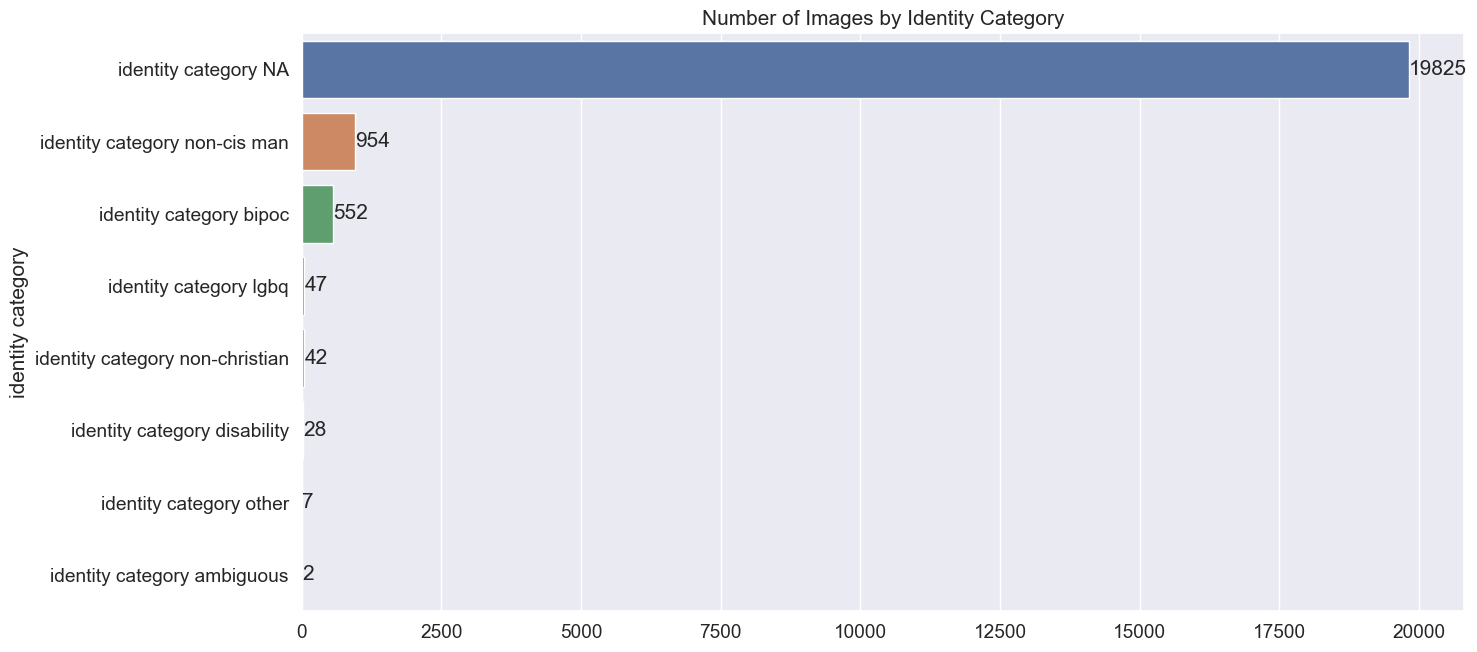

In [954]:
# show distribution among identity_category
identity_cols = [col for col in object_wall_hanging_df.columns if col.startswith("identity category")]
identity_df = object_wall_hanging_df[identity_cols]
identity_df = identity_df.melt(var_name="identity category", value_name="selected")
identity_df = identity_df[identity_df["selected"] == True]
identity_df_counts = identity_df["identity category"].value_counts()

# add missing categories and set to 0
for identity_category in identity_information_with_prefix:
    if identity_category not in identity_df_counts.index:
        identity_df_counts[identity_category] = 0

images_by_identity_category = sns.barplot(x=identity_df_counts.values, y=identity_df_counts.index)
images_by_identity_category.set_title("Number of Images by Identity Category")

for p in images_by_identity_category.patches:
    width = p.get_width()
    images_by_identity_category.text(width + 3, p.get_y() + p.get_height()/2.,
            '{:d}'.format(int(width)), 
            ha="left", va="center")

figure = images_by_identity_category.get_figure()
figure.savefig("../object_wall_hanging_report/images_by_identity_category.png", bbox_inches="tight")